# Myers-Briggs Personality Classification with ML algorithms

### Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
from nltk import FreqDist
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from collections import Counter
from itertools import chain
# import contractions
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder
from nltk.collocations import TrigramAssocMeasures, TrigramCollocationFinder
from nltk import ngrams

In [ ]:
!pip install contractions

import contractions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 5.4 MB/s eta 0:00:00


### Load Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv("/content/drive/MyDrive/balanced_data.csv")
data.head()

,type,posts
0,ISFJ,Everything you said here is spot on.|||Ti = 62...
1,ESFP,"That's okay, everybody has their preferences. ..."
2,ENFJ,"I laughed so hard at the post, and especially ..."
3,ISFP,My best friend and bass player in my band is I...
4,ESFJ,Birds of prey always look angry. It's the... b...


#### some information about dataset

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29312 entries, 0 to 29311
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    29312 non-null  object
 1   posts   29312 non-null  object
dtypes: object(2)
memory usage: 458.1+ KB


In [ ]:
data.describe()

,type,posts
count,29312,29312
unique,16,29312
top,ISFJ,Everything you said here is spot on.|||Ti = 62...
freq,1832,1


### Class Distribution

In [ ]:
_classes = data.type.unique()
print(_classes)

['ISFJ' 'ESFP' 'ENFJ' 'ISFP' 'ESFJ' 'ENFP' 'ESTP' 'INFP' 'ENTJ' 'INFJ'
 'ISTP' 'INTJ' 'ISTJ' 'INTP' 'ESTJ' 'ENTP']


In [ ]:
def show_class_distribution(data, x="type", figsize=(16,4), title="Distribution of Personality Types", xticks_size=10, palette="husl"):
    plt.figure(figsize=figsize)
    sns.countplot(x=x, data=data, palette=palette)
    plt.xlabel("Personality Types", size=15)
    plt.ylabel("Counts", size=15)
    plt.xticks(size=xticks_size)
    plt.title(title, size=20)
    plt.show()

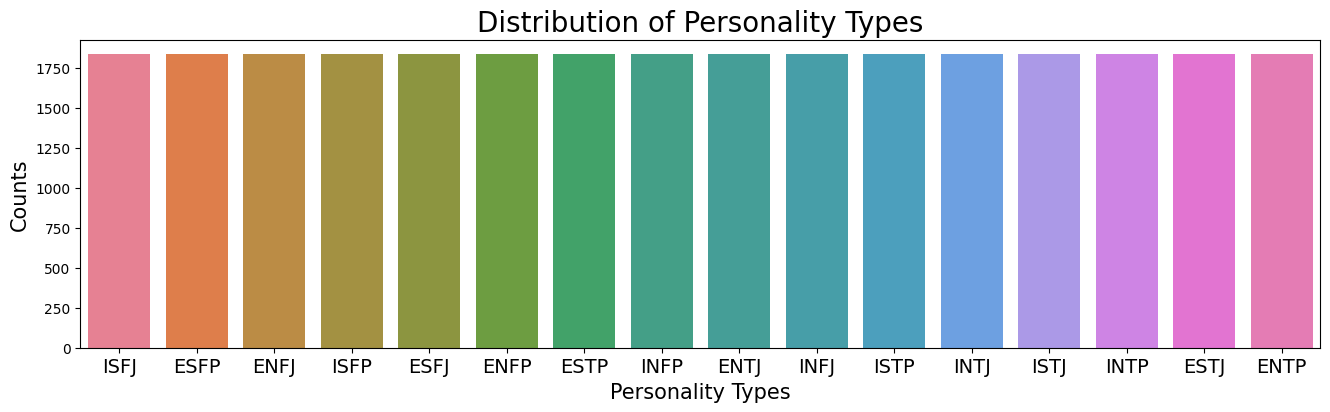

In [ ]:
show_class_distribution(data, xticks_size=14)

In [ ]:
def divide_types(df):
    df["E-I"] = ""
    df["N-S"] = ""
    df["F-T"] = ""
    df["J-P"] = ""
    for index, row in df.iterrows():
        row["E-I"] = "E" if row.type[0] == "E" else "I"
        row["N-S"] = "N" if row.type[1] == "N" else "S"
        row["F-T"] = "F" if row.type[2] == "F" else "T"
        row["J-P"] = "J" if row.type[3] == "J" else "P"
    return df

data = divide_types(data)

#### sample post

In [ ]:
data.loc[7, "posts"]

"'While yes you could talk about the carrots, but that would be just as true for the ENTP. We both use Ne as out primary function. So the fact that you would have strong opinions or ideas about a topic...|||Yeah, Go saffron! That was well said, concise, and accurate. Especially that bit about the dollar being over inflated, spot on! I'm impressed. Thank you for having the energy to do what I couldn't!|||Not me. I think I sound terrible. If you know about sound design I feel like my voice is muddy on the lowends, and not very clear. I kinda of want to see a speech pathologist.|||I am mistaken for a T quite a bit. I mistook my ENFP best friend for a T-- but then in retrospect I see how he is totally an F-- We tell each other, i love you. On the phone. (we are two straight...|||I am the worst when deciding plans to do with people. I offer no advice.|||I would have to agree with the out of sight out of mind thing. It can be pretty bad for maintaining any long term friendships that are sepa

### Cleaning

In [ ]:
def fix_contractions(df, column_name = "posts", new_column="cleaned_post"):
    df[new_column] = df[column_name].apply(lambda x: contractions.fix(x))
    return df

data = fix_contractions(data)

In [ ]:
def clean_data(df, column_name = "cleaned_post"):
    df[column_name] = df[column_name].apply(lambda x: x.lower())
    df[column_name] = df[column_name].apply(lambda x: re.sub(r'@([a-zA-Z0-9_]{1,50})', '', x))
    df[column_name] = df[column_name].apply(lambda x: re.sub(r'#([a-zA-Z0-9_]{1,50})', '', x))
    df[column_name] = df[column_name].apply(lambda x: re.sub(r'http[s]?://\S+', '', x))
    df[column_name] = df[column_name].apply(lambda x: re.sub(r'[^A-Za-z]+', ' ', x))
    df[column_name] = df[column_name].apply(lambda x: re.sub(r' +', ' ', x))
    df[column_name] = df[column_name].apply(lambda x: " ".join([word for word in x.split() if not len(word) <3]))
    return df

data = clean_data(data)

#### cleaned post

In [ ]:
data.loc[7,"cleaned_post"]

'while yes you could talk about the carrots but that would just true for the entp both use out primary function the fact that you would have strong opinions ideas about topic yeah saffron that was well said concise and accurate especially that bit about the dollar being over inflated spot impressed thank you for having the energy what could not not think sound terrible you know about sound design feel like voice muddy the lowends and not very clear kind want see speech pathologist mistaken for quite bit mistook enfp best friend for but then retrospect see how totally tell each other love you the phone are two straight the worst when deciding plans with people offer advice would have agree with the out sight out mind thing can pretty bad for maintaining any long term friendships that are separated distance have you ever been public setting where some one says something outlandish yet with such conviction that there just absolutely way attack mean the argument just nebulous got but yeah 

In [ ]:
data["words_count"] = data["cleaned_post"].apply(lambda x: len(x.split()))
data.head(5)

,type,posts,E-I,N-S,F-T,J-P,cleaned_post,words_count
0,ISFJ,Everything you said here is spot on.|||Ti = 62...,I,S,F,J,everything you said here spot mmmmmmmm ekac no...,610
1,ESFP,"That's okay, everybody has their preferences. ...",E,S,F,P,that okay everybody has their preferences also...,760
2,ENFJ,"I laughed so hard at the post, and especially ...",E,N,F,J,laughed hard the post and especially this line...,797
3,ISFP,My best friend and bass player in my band is I...,I,S,F,P,best friend and bass player band intp fun most...,820
4,ESFJ,Birds of prey always look angry. It's the... b...,E,S,F,J,birds prey always look angry the bits that wou...,813


In [ ]:
def plot_counts(df, column, xlabel):
    fig = plt.figure()
    plt.xlabel(xlabel)
    plt.ylabel("Frequency")
    df[column].plot.hist(bins=25)

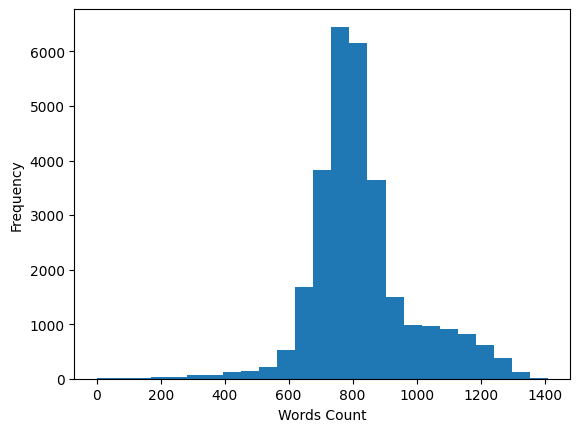

In [ ]:
plot_counts(data, column="words_count", xlabel="Words Count")

In [ ]:
data["char_count"] = data["cleaned_post"].apply(lambda x: len(x))
data.head(5)

,type,posts,E-I,N-S,F-T,J-P,cleaned_post,words_count,char_count
0,ISFJ,Everything you said here is spot on.|||Ti = 62...,I,S,F,J,everything you said here spot mmmmmmmm ekac no...,610,3600
1,ESFP,"That's okay, everybody has their preferences. ...",E,S,F,P,that okay everybody has their preferences also...,760,4598
2,ENFJ,"I laughed so hard at the post, and especially ...",E,N,F,J,laughed hard the post and especially this line...,797,4644
3,ISFP,My best friend and bass player in my band is I...,I,S,F,P,best friend and bass player band intp fun most...,820,5047
4,ESFJ,Birds of prey always look angry. It's the... b...,E,S,F,J,birds prey always look angry the bits that wou...,813,4879


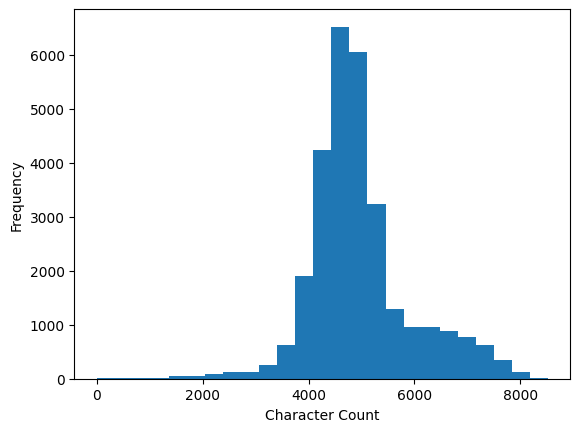

In [ ]:
plot_counts(data, column="char_count", xlabel="Character Count")

### Most Frequent Words

In [ ]:
nltk.download('stopwords')
stopword_list = stopwords.words("english")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def get_most_frequent(data, stop_words, column="cleaned_post", top=25):
    df = data[column].apply(lambda x: " ".join([word for word in x.split() if not word in stop_words]))
    counter = Counter(" ".join(df).split())
    return counter.most_common(top)

In [ ]:
most_frequents = get_most_frequent(data, stopword_list)
most_frequents[:10]

[('like', 210106),
 ('would', 157598),
 ('think', 151893),
 ('people', 142121),
 ('know', 116036),
 ('one', 108160),
 ('really', 104742),
 ('get', 96442),
 ('time', 81970),
 ('well', 70988)]

### N-Grams

In [ ]:
def get_ngrams(data, n_gram, new_column, column="cleaned_post"):
    data["tokenized"]  = data[column].apply(lambda x: x.split())
    data["sw_removal"] = data["tokenized"].apply(lambda x: [y for y in x if not y in stopword_list])
    data[new_column]   = data["sw_removal"].apply(lambda x: list(ngrams(x, n_gram)))
    data.drop(columns  = ["tokenized", "sw_removal"], inplace=True)
    return data

In [ ]:
data = get_ngrams(data, n_gram=2, new_column="bigrams")
data.head()

,type,posts,E-I,N-S,F-T,J-P,cleaned_post,words_count,char_count,bigrams
0,ISFJ,Everything you said here is spot on.|||Ti = 62...,I,S,F,J,everything you said here spot mmmmmmmm ekac no...,610,3600,"[(everything, said), (said, spot), (spot, mmmm..."
1,ESFP,"That's okay, everybody has their preferences. ...",E,S,F,P,that okay everybody has their preferences also...,760,4598,"[(okay, everybody), (everybody, preferences), ..."
2,ENFJ,"I laughed so hard at the post, and especially ...",E,N,F,J,laughed hard the post and especially this line...,797,4644,"[(laughed, hard), (hard, post), (post, especia..."
3,ISFP,My best friend and bass player in my band is I...,I,S,F,P,best friend and bass player band intp fun most...,820,5047,"[(best, friend), (friend, bass), (bass, player..."
4,ESFJ,Birds of prey always look angry. It's the... b...,E,S,F,J,birds prey always look angry the bits that wou...,813,4879,"[(birds, prey), (prey, always), (always, look)..."


In [ ]:
data = get_ngrams(data, n_gram=3, new_column="trigrams")
data.head()

,type,posts,E-I,N-S,F-T,J-P,cleaned_post,words_count,char_count,bigrams,trigrams
0,ISFJ,Everything you said here is spot on.|||Ti = 62...,I,S,F,J,everything you said here spot mmmmmmmm ekac no...,610,3600,"[(everything, said), (said, spot), (spot, mmmm...","[(everything, said, spot), (said, spot, mmmmmm..."
1,ESFP,"That's okay, everybody has their preferences. ...",E,S,F,P,that okay everybody has their preferences also...,760,4598,"[(okay, everybody), (everybody, preferences), ...","[(okay, everybody, preferences), (everybody, p..."
2,ENFJ,"I laughed so hard at the post, and especially ...",E,N,F,J,laughed hard the post and especially this line...,797,4644,"[(laughed, hard), (hard, post), (post, especia...","[(laughed, hard, post), (hard, post, especiall..."
3,ISFP,My best friend and bass player in my band is I...,I,S,F,P,best friend and bass player band intp fun most...,820,5047,"[(best, friend), (friend, bass), (bass, player...","[(best, friend, bass), (friend, bass, player),..."
4,ESFJ,Birds of prey always look angry. It's the... b...,E,S,F,J,birds prey always look angry the bits that wou...,813,4879,"[(birds, prey), (prey, always), (always, look)...","[(birds, prey, always), (prey, always, look), ..."


In [ ]:
def most_common_ngram(data, column, top=20):
    temp = []
    for index, row in data.iterrows():
        temp += row[column]
    most_common = Counter(temp).most_common(top)
    return most_common

In [ ]:
def plot_n_grams(ngrams, title, top=20):
    ngram_df = pd.DataFrame(ngrams)
    ngram_df.iloc[:, 0] = ngram_df.iloc[:,0].astype(str)
    plt.figure(figsize=(7,7))
    plt.barh(y=ngram_df.iloc[:top, 0], width=ngram_df.iloc[:top, 1])
    plt.xlabel("Counts", size=17)
    plt.ylabel("Pairs", size=17)
    plt.title(title, size = 20)
    plt.show() 

In [ ]:
bigrams_most_common = most_common_ngram(data, "bigrams")
bigrams_most_common

[(('feel', 'like'), 16030),
 (('would', 'say'), 13264),
 (('would', 'like'), 10003),
 (('sounds', 'like'), 8485),
 (('pretty', 'much'), 7243),
 (('high', 'school'), 6880),
 (('even', 'though'), 5775),
 (('seems', 'like'), 5774),
 (('using', 'tapatalk'), 5520),
 (('best', 'friend'), 5472),
 (('get', 'along'), 5272),
 (('think', 'would'), 4683),
 (('really', 'like'), 4545),
 (('personality', 'type'), 4480),
 (('long', 'time'), 4472),
 (('years', 'ago'), 4178),
 (('sent', 'iphone'), 3734),
 (('someone', 'else'), 3734),
 (('one', 'thing'), 3572),
 (('makes', 'sense'), 3540)]

In [ ]:
trigrams_most_common = most_common_ngram(data, "trigrams")
trigrams_most_common

[(('sent', 'iphone', 'using'), 3318),
 (('iphone', 'using', 'tapatalk'), 3173),
 (('happy', 'happy', 'happy'), 1224),
 (('sent', 'using', 'tapatalk'), 1137),
 (('one', 'best', 'friends'), 843),
 (('get', 'along', 'well'), 836),
 (('anything', 'may', 'affect'), 782),
 (('may', 'affect', 'way'), 780),
 (('affect', 'way', 'answer'), 766),
 (('way', 'answer', 'questions'), 701),
 (('answer', 'questions', 'example'), 673),
 (('questions', 'example', 'stressful'), 662),
 (('example', 'stressful', 'time'), 660),
 (('sometimes', 'feel', 'like'), 637),
 (('stressful', 'time', 'mental'), 605),
 (('time', 'mental', 'illness'), 593),
 (('mental', 'illness', 'medications'), 587),
 (('low', 'self', 'esteem'), 573),
 (('illness', 'medications', 'special'), 565),
 (('would', 'like', 'know'), 557)]

### preprocessing

In [ ]:
def remove_stopwords(data, stopword_list, column="cleaned_post"):
    data[column] = data[column].apply(word_tokenize)
    data[column] = data[column].apply(lambda x: [word for word in x if not word in stopword_list])
    return data

In [ ]:
def apply_lemmatization(text):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(w) for w in text]

In [ ]:
def lemmatize(data, stopword_list, column="cleaned_post"):
    data[column] = data[column].apply(apply_lemmatization)
    data[column] = data[column].apply(" ".join)
    return data

In [ ]:
nltk.download('punkt')
data = remove_stopwords(data, stopword_list)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
nltk.download('wordnet')
data = lemmatize(data, stopword_list)

[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
data.head()

,type,posts,E-I,N-S,F-T,J-P,cleaned_post,words_count,char_count,bigrams,trigrams
0,ISFJ,Everything you said here is spot on.|||Ti = 62...,I,S,F,J,everything said spot mmmmmmmm ekac sure someon...,610,3600,"[(everything, said), (said, spot), (spot, mmmm...","[(everything, said, spot), (said, spot, mmmmmm..."
1,ESFP,"That's okay, everybody has their preferences. ...",E,S,F,P,okay everybody preference also like korra much...,760,4598,"[(okay, everybody), (everybody, preferences), ...","[(okay, everybody, preferences), (everybody, p..."
2,ENFJ,"I laughed so hard at the post, and especially ...",E,N,F,J,laughed hard post especially line true thanks ...,797,4644,"[(laughed, hard), (hard, post), (post, especia...","[(laughed, hard, post), (hard, post, especiall..."
3,ISFP,My best friend and bass player in my band is I...,I,S,F,P,best friend bass player band intp fun time get...,820,5047,"[(best, friend), (friend, bass), (bass, player...","[(best, friend, bass), (friend, bass, player),..."
4,ESFJ,Birds of prey always look angry. It's the... b...,E,S,F,J,bird prey always look angry bit would eyebrow ...,813,4879,"[(birds, prey), (prey, always), (always, look)...","[(birds, prey, always), (prey, always, look), ..."


In [ ]:
training_data = data[["cleaned_post", "E-I", "N-S", "F-T", "J-P"]].copy()
training_data.head(5)

,cleaned_post,E-I,N-S,F-T,J-P
0,everything said spot mmmmmmmm ekac sure someon...,I,S,F,J
1,okay everybody preference also like korra much...,E,S,F,P
2,laughed hard post especially line true thanks ...,E,N,F,J
3,best friend bass player band intp fun time get...,I,S,F,P
4,bird prey always look angry bit would eyebrow ...,E,S,F,J


In [ ]:
def make_dummies(data, columns=["E-I", "N-S", "F-T", "J-P"]):
    for column in columns:
        temp_dummy = pd.get_dummies(data[column], prefix="type")
        data = data.join(temp_dummy)
    return data

In [ ]:
training_data = make_dummies(training_data)
training_data.head()

,cleaned_post,E-I,N-S,F-T,J-P,type_E,type_I,type_N,type_S,type_F,type_T,type_J,type_P
0,everything said spot mmmmmmmm ekac sure someon...,I,S,F,J,0,1,0,1,1,0,1,0
1,okay everybody preference also like korra much...,E,S,F,P,1,0,0,1,1,0,0,1
2,laughed hard post especially line true thanks ...,E,N,F,J,1,0,1,0,1,0,1,0
3,best friend bass player band intp fun time get...,I,S,F,P,0,1,0,1,1,0,0,1
4,bird prey always look angry bit would eyebrow ...,E,S,F,J,1,0,0,1,1,0,1,0


#### Handling Imbalanced Data

In [ ]:
X = training_data[["cleaned_post"]]
y = training_data.drop(columns=["cleaned_post"])


In [ ]:
print(X)

                                            cleaned_post
0      everything said spot mmmmmmmm ekac sure someon...
1      okay everybody preference also like korra much...
2      laughed hard post especially line true thanks ...
3      best friend bass player band intp fun time get...
4      bird prey always look angry bit would eyebrow ...
...                                                  ...
29307  think conversation back similar believe conclu...
29308  friend girl seven year shit finally hit fan to...
29309  wow beleave read glad date infp done long dist...
29310  could probably use advice think bit hang actua...
29311  thing today breakfast bed boyfriend people ord...

[29312 rows x 1 columns]


In [ ]:
print(y)

      E-I N-S F-T J-P  type_E  type_I  type_N  type_S  type_F  type_T  type_J  \
0       I   S   F   J       0       1       0       1       1       0       1   
1       E   S   F   P       1       0       0       1       1       0       0   
2       E   N   F   J       1       0       1       0       1       0       1   
3       I   S   F   P       0       1       0       1       1       0       0   
4       E   S   F   J       1       0       0       1       1       0       1   
...    ..  ..  ..  ..     ...     ...     ...     ...     ...     ...     ...   
29307   I   S   T   J       0       1       0       1       0       1       1   
29308   E   S   F   P       1       0       0       1       1       0       0   
29309   I   S   T   P       0       1       0       1       0       1       0   
29310   E   N   T   P       1       0       1       0       0       1       0   
29311   I   S   F   J       0       1       0       1       1       0       1   

       type_P  
0          

<ipython-input-42-3cfbcdedffe2>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,4, j+1)


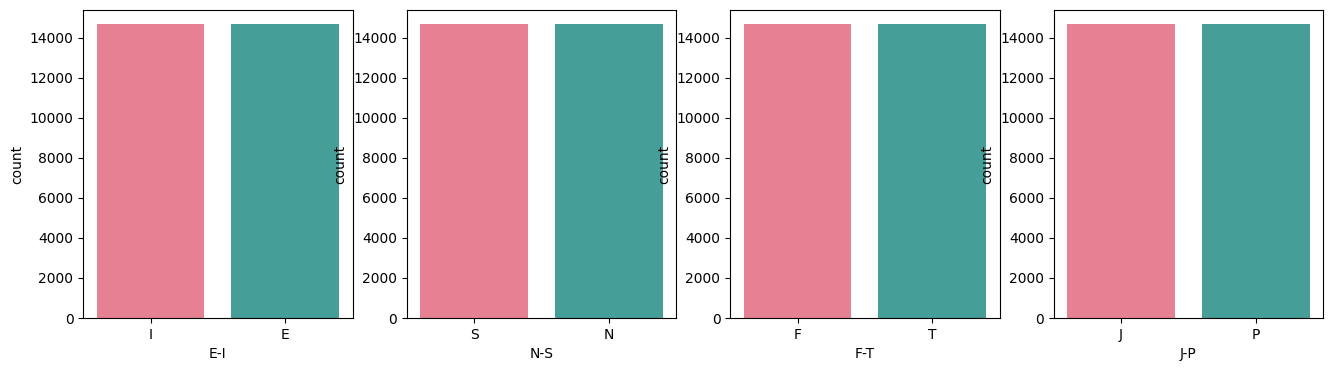

In [ ]:
def show_distribution(data, x=["E-I", "N-S", "F-T","J-P"], fig_size=(16,4), xticks_size=10, palette="husl"):
    fig, ax = plt.subplots(len(x), figsize=fig_size)
    j = 0
    for _x in x:
        plt.subplot(1,4, j+1)
        sns.countplot(x=_x, data=data, palette=palette)
        plt.xticks(size=xticks_size)
        j+=1    
        
show_distribution(data)

In [ ]:
from imblearn.over_sampling import RandomOverSampler

In [ ]:
oversample = RandomOverSampler()

In [ ]:
y_ei = y["type_E"]
y_ns = y["type_N"]
y_ft = y["type_F"]
y_jp = y["type_J"]

In [ ]:
from nltk.tokenize import word_tokenize

def tokener(X):
  X['cleaned_post'] = X['cleaned_post'].apply(lambda x: x.lower())  # convert to lowercase
  X['cleaned_post'] = X['cleaned_post'].apply(lambda x: word_tokenize(x))  # tokenize the cleaned_post
  return X

In [ ]:
X = tokener(X)
X.head()

<ipython-input-46-5bedc636f128>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['cleaned_post'] = X['cleaned_post'].apply(lambda x: x.lower())  # convert to lowercase
<ipython-input-46-5bedc636f128>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['cleaned_post'] = X['cleaned_post'].apply(lambda x: word_tokenize(x))  # tokenize the cleaned_post


,cleaned_post
0,"[everything, said, spot, mmmmmmmm, ekac, sure,..."
1,"[okay, everybody, preference, also, like, korr..."
2,"[laughed, hard, post, especially, line, true, ..."
3,"[best, friend, bass, player, band, intp, fun, ..."
4,"[bird, prey, always, look, angry, bit, would, ..."


#### Train-test split for each classes

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train,X_test,Y_train,Y_test = train_test_split(X,y,test_size=0.2,random_state=42)

y_ei_new = Y_train["type_E"]
y_ns_new = Y_train["type_N"]
y_ft_new = Y_train["type_F"]
y_jp_new = Y_train["type_J"]

y_ei_test = Y_test["type_E"]
y_ns_test = Y_test["type_N"]
y_ft_test = Y_test["type_F"]
y_jp_test = Y_test["type_J"]

In [ ]:
X_train_ei, X_test_ei, y_train_ei, y_test_ei = train_test_split(X, y_ei, test_size=0.2, random_state=42)
X_train_ns, X_test_ns, y_train_ns, y_test_ns = train_test_split(X, y_ns, test_size=0.2, random_state=42)
X_train_ft, X_test_ft, y_train_ft, y_test_ft = train_test_split(X, y_ft, test_size=0.2, random_state=42)
X_train_jp, X_test_jp, y_train_jp, y_test_jp = train_test_split(X, y_jp, test_size=0.2, random_state=42)

print(y_train_ei)

8132     0
7889     1
1350     0
14006    0
6460     0
        ..
21575    0
5390     0
860      1
15795    1
23654    0
Name: type_E, Length: 23449, dtype: uint8


In [ ]:
y_train_ei.name, y_test_ei.name = "E-I", "E-I"
y_train_ns.name, y_test_ns.name = "N-S", "N-S"
y_train_ft.name, y_test_ft.name = "F-T", "F-T"
y_train_jp.name, y_test_jp.name = "J-P", "J-P"

y_ei_new.name,y_ei_test.name = "E-I", "E-I"
y_ns_new.name,y_ns_test.name = "N-S", "N-S"
y_ft_new.name, y_ft_test.name = "F-T", "F-T"
y_jp_new.name, y_jp_test.name = "J-P", "J-P"

In [ ]:
import pandas as pd
import gensim
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser
import multiprocessing

In [ ]:
# Train the Word2Vec model
model = Word2Vec(X['cleaned_post'], vector_size=1000, window=10, min_count=1, workers=4, sg=1)

In [ ]:
def sentence_to_vector(sentence):
    words = sentence
    vectors = []
    for word in words:
        if word in model.wv.key_to_index:
            vectors.append(model.wv[word])
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)


In [ ]:
import numpy as np

X_train['vector_column'] = X_train['cleaned_post'].apply(sentence_to_vector)
X_test['vector_column'] = X_test['cleaned_post'].apply(sentence_to_vector)

X_train_ei['vector_column'] = X_train_ei['cleaned_post'].apply(sentence_to_vector)
X_test_ei['vector_column'] = X_test_ei['cleaned_post'].apply(sentence_to_vector)

X_train_ns['vector_column'] = X_train_ns['cleaned_post'].apply(sentence_to_vector)
X_test_ns['vector_column'] = X_test_ns['cleaned_post'].apply(sentence_to_vector)

X_train_ft['vector_column'] = X_train_ft['cleaned_post'].apply(sentence_to_vector)
X_test_ft['vector_column'] = X_test_ft['cleaned_post'].apply(sentence_to_vector)

X_train_jp['vector_column'] = X_train_jp['cleaned_post'].apply(sentence_to_vector)
X_test_jp['vector_column'] = X_test_jp['cleaned_post'].apply(sentence_to_vector)


In [ ]:
#case - 2
X_train_set = [X_train_ei,X_train_ns,X_train_ft,X_train_jp]
X_test_set = [X_test_ei,X_test_ns,X_test_ft,X_test_jp]

y_train_set = [y_ei_new,y_ns_new,y_ft_new,y_jp_new]
y_test_set = [y_ei_test,y_ns_test,y_ft_test,y_jp_test]

In [ ]:
!pip install xgboost

from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost
import pickle
from sklearn import metrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Model Creation & Model Training & Model Saving

In [ ]:
def create_models():
    svm_clf = SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
    dt_clf  = DecisionTreeClassifier(max_depth=7)
    rf_clf  = RandomForestClassifier(n_estimators=750)
    xgb_clf = xgboost.XGBClassifier(use_label_encoder=False)
    return {"SVM":svm_clf, "DecisionTree":dt_clf, "RandomForest":rf_clf, "Xgboost":xgb_clf}

#### Model Performance Evaluation with accuracy & f1-score & roc-auc score

In [ ]:
_metrics = ["Accuracy", "Accuracy", "Accuracy" ,"Accuracy", "Precision", "Precision", "Precision","Precision", "Recall","Recall","Recall","Recall", "F1-Score", "F1-Score", "F1-Score", "F1-Score", "Roc-Auc Score", "Roc-Auc Score", "Roc-Auc Score", "Roc-Auc Score"]
_types   = ["E-I", "N-S", "F-T", "J-P", "E-I", "N-S", "F-T", "J-P", "E-I", "N-S", "F-T", "J-P","E-I", "N-S", "F-T", "J-P","E-I", "N-S", "F-T", "J-P"]
_columns = ["SVM", "DecisionTree", "RandomForest", "Xgboost"]

In [ ]:
evaluation_df = pd.DataFrame(columns=_columns, index=[_metrics, _types])
evaluation_df

SVM DecisionTree RandomForest Xgboost
Accuracy      E-I  NaN          NaN          NaN     NaN
              N-S  NaN          NaN          NaN     NaN
              F-T  NaN          NaN          NaN     NaN
              J-P  NaN          NaN          NaN     NaN
Precision     E-I  NaN          NaN          NaN     NaN
              N-S  NaN          NaN          NaN     NaN
              F-T  NaN          NaN          NaN     NaN
              J-P  NaN          NaN          NaN     NaN
Recall        E-I  NaN          NaN          NaN     NaN
              N-S  NaN          NaN          NaN     NaN
              F-T  NaN          NaN          NaN     NaN
              J-P  NaN          NaN          NaN     NaN
F1-Score      E-I  NaN          NaN          NaN     NaN
              N-S  NaN          NaN          NaN     NaN
              F-T  NaN          NaN          NaN     NaN
              J-P  NaN          NaN          NaN     NaN
Roc-Auc Score E-I  NaN          NaN          NaN     NaN
              N-S  NaN          NaN          NaN     NaN
              F-T  NaN          NaN          NaN     NaN
              J-P  NaN          NaN          NaN     NaN

In [ ]:
models = create_models()
models

/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


{'SVM': SVC(gamma='auto', kernel='linear'),
 'DecisionTree': DecisionTreeClassifier(max_depth=7),
 'RandomForest': RandomForestClassifier(n_estimators=750),
 'Xgboost': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=100, n_jobs=None, num_parallel_tree=None,
               predictor=None, random_state=None, ...)}

In [ ]:
for model_item in models.items():
    for x_t,x_te,y_train, y_test in zip(X_train_set,X_test_set,y_train_set, y_test_set):
        # Model creation and prediction
        ml_model = model_item[1]
        print(f"{model} is training for {y_train.name}...")
        # # print(X_train.values.tolist)
        # # print(X_train['vector_column']val)
        # print(len(y_train_ei.values))
        # print(len(y_train.values))
        ml_model.fit(x_t['vector_column'].values.tolist(), y_train.values.tolist())
        
        pred = ml_model.predict(x_te['vector_column'].values.tolist())
        # Performance evaluation metrics
        evaluation_df.loc["Accuracy",y_train.name][model_item[0]]      = round(metrics.accuracy_score(y_test, pred), 3)
        evaluation_df.loc["Precision",y_train.name][model_item[0]]     = round(metrics.precision_score(y_test, pred), 3)
        evaluation_df.loc["Recall",y_train.name][model_item[0]]        = round(metrics.recall_score(y_test, pred), 3)        
        evaluation_df.loc["F1-Score",y_train.name][model_item[0]]      = round(metrics.f1_score(y_test, pred), 3)
        evaluation_df.loc["Roc-Auc Score",y_train.name][model_item[0]] = round(metrics.roc_auc_score(y_test, pred), 3)

Word2Vec<vocab=87686, vector_size=1000, alpha=0.025> is training for E-I...
Word2Vec<vocab=87686, vector_size=1000, alpha=0.025> is training for N-S...
Word2Vec<vocab=87686, vector_size=1000, alpha=0.025> is training for F-T...
Word2Vec<vocab=87686, vector_size=1000, alpha=0.025> is training for J-P...
Word2Vec<vocab=87686, vector_size=1000, alpha=0.025> is training for E-I...
Word2Vec<vocab=87686, vector_size=1000, alpha=0.025> is training for N-S...
Word2Vec<vocab=87686, vector_size=1000, alpha=0.025> is training for F-T...
Word2Vec<vocab=87686, vector_size=1000, alpha=0.025> is training for J-P...
Word2Vec<vocab=87686, vector_size=1000, alpha=0.025> is training for E-I...
Word2Vec<vocab=87686, vector_size=1000, alpha=0.025> is training for N-S...
Word2Vec<vocab=87686, vector_size=1000, alpha=0.025> is training for F-T...
Word2Vec<vocab=87686, vector_size=1000, alpha=0.025> is training for J-P...
Word2Vec<vocab=87686, vector_size=1000, alpha=0.025> is training for E-I...
Word2Vec<voc

In [ ]:
evaluation_df

SVM DecisionTree RandomForest Xgboost
Accuracy      E-I  0.917        0.726        0.852   0.903
              N-S  0.954        0.771        0.901   0.937
              F-T  0.937        0.777        0.906   0.923
              J-P  0.874        0.698        0.832   0.854
Precision     E-I  0.939        0.753        0.903   0.919
              N-S  0.951        0.759        0.882   0.932
              F-T  0.943        0.794        0.914   0.927
              J-P  0.885        0.705        0.845    0.86
Recall        E-I  0.896        0.684        0.793   0.886
              N-S  0.958        0.803        0.928   0.944
              F-T   0.93        0.749        0.896   0.918
              J-P   0.86        0.685        0.815   0.848
F1-Score      E-I  0.917        0.717        0.844   0.902
              N-S  0.954        0.781        0.905   0.938
              F-T  0.936        0.771        0.905   0.922
              J-P  0.872        0.695         0.83   0.854
Roc-Auc Score E-I  0.918        0.727        0.853   0.903
              N-S  0.954        0.771          0.9   0.936
              F-T  0.937        0.777        0.906   0.923
              J-P  0.874        0.698        0.832   0.854